In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import data
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

2022-07-07 15:48:42.890718: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-07 15:48:42.890761: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
rs = data.load_fitted_results()

100%|██████████| 72/72 [01:05<00:00,  1.10it/s]


# best models table

In [ ]:
def rename_checkpoint(checkpoint):
    if '/' in checkpoint:
        return 'bert-finetuned'
    else:
        return checkpoint

rfull = rs[rs.subsample == -1]
ans = defaultdict(list)
ind_dsets = []
for k, group in rfull.groupby('dataset'):
    ind_dsets.append(k)
#     print(k, group)
    gg = group.groupby('checkpoint')
#     gg[]
    for kk, ggroup in gg:
        
        ans[rename_checkpoint(kk)].append(ggroup['acc_val'].max())
        
tab = pd.DataFrame.from_dict(ans).round(3)
tab.index = map(data.DSETS_RENAME_DICT.get, ind_dsets, ind_dsets)
tab.columns = map(data.COLUMNS_RENAME_DICT.get, tab.columns)
# tab.style.highlight_max(color = 'lightgreen', axis=1)
tab

In [53]:
def bold_extreme_values(data):
    format_string="%.2f"
    max_=True
    if max_:
        extrema = data != data.max()
    else:
        extrema = data != data.min()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

tab = tab.apply(bold_extreme_values, axis=1)
print(tab.to_latex(escape=False))

\begin{tabular}{lllll}
\toprule
{} &  BERT &  Bag of ngrams & BERT finetuned & TF-IDF \\
\midrule
Emotion         &  0.58 &           0.89 &  \textbf{0.90} &   0.89 \\
Rotten tomatoes &  0.78 &           0.75 &  \textbf{0.81} &   0.76 \\
SST2            &  0.81 &           0.82 &  \textbf{0.87} &   0.84 \\
Tweet (Hate)    &  0.72 &  \textbf{0.74} &           0.72 &   0.72 \\
\bottomrule
\end{tabular}



# all curves

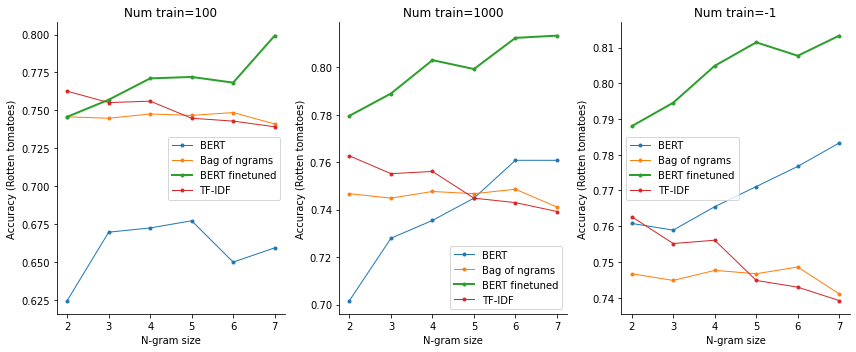

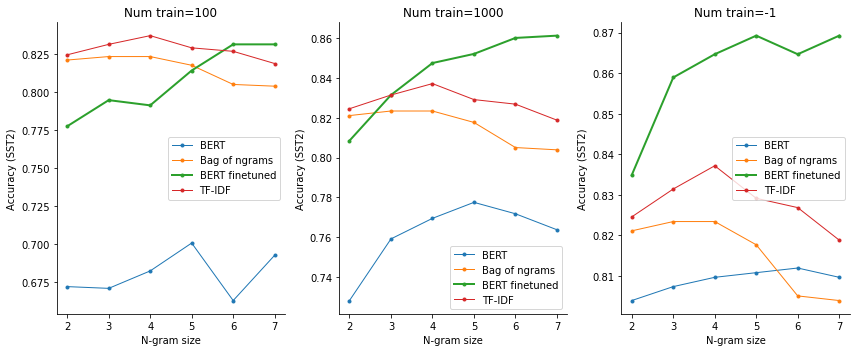

In [61]:
for dset in ['rotten_tomatoes', 'sst2']: # rs.dataset.unique():
    r = rs[rs.dataset == dset]

    R = 1
    C = 3
    plt.figure(figsize=(12, 5))
    # plt.figure(figsize=(8, 12))
    for i, subsample in enumerate([100, 1000, -1]):
        plt.subplot(R, C, i + 1)
        plt.title('Num train=' + str(subsample))
        d = r[r.subsample == subsample]

        curve = d.groupby(['checkpoint', 'all', 'norm'])
        for key, group in curve:
            g = group.sort_values('ngrams')
            label = data.COLUMNS_RENAME_DICT.get(key[0], 'BERT finetuned')
            lw = 2 if label == 'BERT finetuned' else 1
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=lw)
        plt.ylabel(f'Accuracy ({data.DSETS_RENAME_DICT.get(dset)})')
        plt.xlabel('N-gram size')
        plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(f'results/acc_by_ngrams_{dset}.pdf')
#     plt.show()    
    #     print(curve)